In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

#hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 20
FEATURES_DISC = 64
FEATURES_GEN = 64

transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

dataset = datasets.FashionMNIST(root="dataset/", train=True, transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 204kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.82MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.8MB/s]


In [2]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # Input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After last block: N x features_d*8 x 4 x 4
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # Input: N x z_dim x 1 x 1
            self._block(z_dim, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(), # Output: N x channels_img x 64 x 64
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.gen(x)

In [3]:
def initialize_weights(model):
    # initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

In [4]:
G_losses = []
D_losses = []

print("Starting Training...")
for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
        fake = gen(noise)

        #Train Discriminator: max log(D(real)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        #Label Smoothing
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real) * 0.9)

        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        #Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}")
            G_losses.append(loss_gen.item())
            D_losses.append(loss_disc.item())

    if epoch % 5 == 0:
        torch.save(gen.state_dict(), f"generator_epoch_{epoch}.pth")

Starting Training...
Epoch [0/20] Batch 0/469 Loss D: 0.6919, loss G: 0.7968
Epoch [0/20] Batch 100/469 Loss D: 0.1957, loss G: 3.1014
Epoch [0/20] Batch 200/469 Loss D: 0.5411, loss G: 1.4983
Epoch [0/20] Batch 300/469 Loss D: 0.6670, loss G: 2.3300
Epoch [0/20] Batch 400/469 Loss D: 0.6140, loss G: 1.1666
Epoch [1/20] Batch 0/469 Loss D: 0.6467, loss G: 1.4108
Epoch [1/20] Batch 100/469 Loss D: 0.6967, loss G: 0.6749
Epoch [1/20] Batch 200/469 Loss D: 0.4680, loss G: 1.8170
Epoch [1/20] Batch 300/469 Loss D: 0.4663, loss G: 2.2011
Epoch [1/20] Batch 400/469 Loss D: 0.4999, loss G: 3.1869
Epoch [2/20] Batch 0/469 Loss D: 0.3710, loss G: 1.9703
Epoch [2/20] Batch 100/469 Loss D: 0.3575, loss G: 2.4321
Epoch [2/20] Batch 200/469 Loss D: 0.3787, loss G: 3.1155
Epoch [2/20] Batch 300/469 Loss D: 0.2745, loss G: 2.9080
Epoch [2/20] Batch 400/469 Loss D: 0.3859, loss G: 1.6672
Epoch [3/20] Batch 0/469 Loss D: 0.2890, loss G: 2.8988
Epoch [3/20] Batch 100/469 Loss D: 0.4234, loss G: 2.6681
E

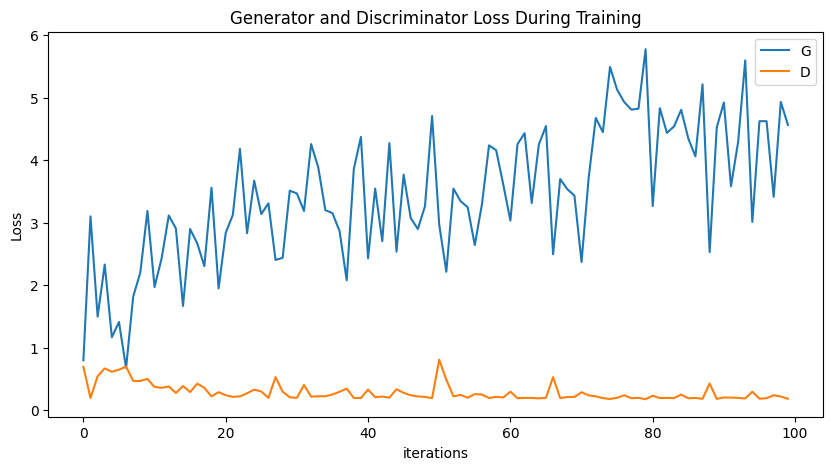

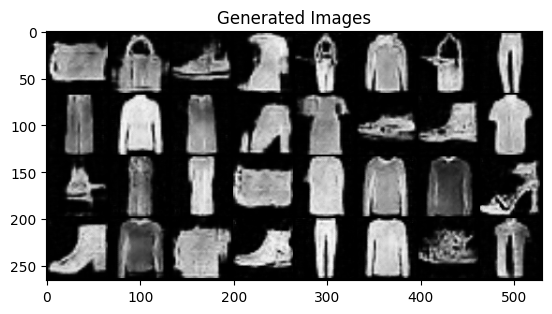

In [5]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

gen.eval()
with torch.no_grad():
    fake_imgs = gen(fixed_noise).detach().cpu()
    img_grid = torchvision.utils.make_grid(fake_imgs, normalize=True)
    plt.imshow(np.transpose(img_grid, (1, 2, 0)))
    plt.title("Generated Images")
    plt.show()